In [1]:
import vertica_python
from sshtunnel import SSHTunnelForwarder
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from workalendar.europe import Turkey
import numpy as np
import seaborn as sns

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
server = SSHTunnelForwarder(
    'host',
    ssh_username="user",
    ssh_password="pass",
    remote_bind_address=('localhost', 5433)
)

server.start()
print(server.local_bind_port)

54487


In [3]:
conn_info = {'host': 'host',
             'port': server.local_bind_port,
             'user': 'dbadmin',
             'password': 'pass',
             'database': 'db'}
connection = vertica_python.connect(**conn_info)

In [4]:
# Functions
x_parameters_milk = ['PRODUCT A_price', 'PRODUCT B_price', 'PRODUCT C_price',
       'PRODUCT D_price', 'PRODUCT E_price']
y_parameters_milk = ['PRODUCT A_weekly_sale', 'PRODUCT B_weekly_sale', 'PRODUCT C_weekly_sale',
       'PRODUCT D_weekly_sale', 'PRODUCT E_weekly_sale']
translate_milk = {'09.19.071.002': 'PRODUCT A', '09.19.170.0001': 'PRODUCT B', '09.19.208.0002': 'PRODUCT C', '09.19.071.0002': 'PRODUCT D', '09.19.002.0003': 'PRODUCT E'}
translate_cheese = {'09.01.071.0009': 'PRODUCT A', '09.01.003.0001': 'PRODUCT B', '09.01.003.0002': 'PRODUCT C'}
rename_dict = {'PRODUCT A_weekly_sale':'PRODUCT A' , 'PRODUCT B_weekly_sale':'PRODUCT B', 'PRODUCT C_weekly_sale':'PRODUCT C',
       'PRODUCT D_weekly_sale': 'PRODUCT D', 'PRODUCT E_weekly_sale': 'PRODUCT E'}

def create_case_df(date, product_type):
    if product_type == 'milk':
        translate = translate_milk
        tail_size = 10
    elif product_type == 'cheese':
        translate = translate_cheese
        tail_size = 6
    case_df = weekly_sales_df[(weekly_sales_df["week_start_day"] <= date)]
    actual_df = pd.pivot_table(case_df.tail(tail_size).replace(translate), values='weekly_sale', index=['week_iso'],
                    columns=['sth_stok_kod'], aggfunc=np.sum).reset_index(drop=True)
    return case_df, actual_df

def predict_from_test_train(test_df, train_df, product_type='milk'):
    if product_type == 'milk':
        x_parameters = x_parameters_milk
        y_parameters = y_parameters_milk
    elif product_type == 'cheese':
        x_parameters = x_parameters_milk[:3]
        y_parameters = y_parameters_milk[:3]
    X = train_df[x_parameters]
    y = train_df[y_parameters]
    model = LinearRegression()
    model.fit(X, y)
    predicted_test = model.predict(test_df[x_parameters])
    predicted_test_df = pd.DataFrame(predicted_test, columns=y_parameters)
    result_df = y.tail(1).append(predicted_test_df)
    result_df.rename(columns=rename_dict, inplace=True)
    return result_df.reset_index(drop=True)

def get_test_train_df(case_df, product_type='milk'):
    if product_type == 'milk':
        translate = translate_milk
    elif product_type == 'cheese':
        translate = translate_cheese
    case_df = pd.pivot_table(case_df.replace(translate), values=['weekly_sale', 'price'], index=['year', 'week_iso'],
                    columns=['sth_stok_kod']).reset_index()
    case_df.columns = case_df.columns.map('{0[1]}_{0[0]}'.format)
    case_df.rename(columns={"_year":"year", "_week_iso":"week"}, inplace=True)
    test_df = case_df.tail(1)
    train_df = case_df.iloc[:len(case_df.index)-1]
    return test_df, train_df

def create_increased_decreased_df(actual_df, predicted_df):
    df = pd.DataFrame(columns=actual_df.columns)
    def create_row(df):
        new_row = {}
        for column in df.columns:
            if df[column][1] > df[column][0]:
                new_row[column] = "Increased"
            else:
                new_row[column] = "Decreased"
        return new_row
    df.loc["actual"] = create_row(actual_df)
    df.loc["predicted"] = create_row(predicted_df)
    return df

In [5]:
# PRODUCT A = '09.19.071.002'
# PRODUCT B = '09.19.170.0001'
# PRODUCT C = '09.19.208.0002'
# PRODUCT D = '09.19.071.0002'
# PRODUCT E = '09.19.002.0003'
stock_codes = ['09.19.071.002', '09.19.170.0001', '09.19.208.0002', '09.19.071.0002', '09.19.002.0003']
stock_query = "('" + "\', \'".join(stock_codes) + "')"
weekly_sales_df = pd.read_sql_query("select year(sth_tarih), week_iso(sth_tarih), min(sth_tarih) as week_start_day, sth_stok_kod ,sto_isim, SUM(Satis_Miktar) as weekly_sale, sum(Satis_Tutar) / SUM(Satis_Miktar) as price from DDE_STOK_GUNLUK where sth_stok_kod in {0} and sth_tarih < '2018-12-24' GROUP BY sto_isim, sth_stok_kod, year(sth_tarih), week_iso(sth_tarih) order by year(sth_tarih), week_iso(sth_tarih) asc".format(stock_query), connection)
weekly_sales_df.head(10)

,year,week_iso,week_start_day,sth_stok_kod,sto_isim,weekly_sale,price
0,2017,1,2017-01-02,09.19.071.002,SUTAS SUT 1 LT GUNLUK PRATIK,217.0,3.008601
1,2017,1,2017-01-02,09.19.208.0002,EKER SUT 1 LT GUNLUK,1112.0,3.238625
2,2017,1,2017-01-02,09.19.170.0001,SEK SUT 1 LT GUNLUK,1523.0,3.655005
3,2017,1,2017-01-02,09.19.071.0002,SUTAS SUT 1 LT GUNLUK SISE,3095.0,3.469474
4,2017,1,2017-01-02,09.19.002.0003,ICIM SUT 1 LT CAM SISE GUNLUK,249.0,3.465939
5,2017,2,2017-01-09,09.19.071.002,SUTAS SUT 1 LT GUNLUK PRATIK,235.0,3.004326
6,2017,2,2017-01-09,09.19.071.0002,SUTAS SUT 1 LT GUNLUK SISE,2959.0,3.469548
7,2017,2,2017-01-09,09.19.002.0003,ICIM SUT 1 LT CAM SISE GUNLUK,246.0,3.931826
8,2017,2,2017-01-09,09.19.208.0002,EKER SUT 1 LT GUNLUK,951.0,3.238240
9,2017,2,2017-01-09,09.19.170.0001,SEK SUT 1 LT GUNLUK,1366.0,3.655175


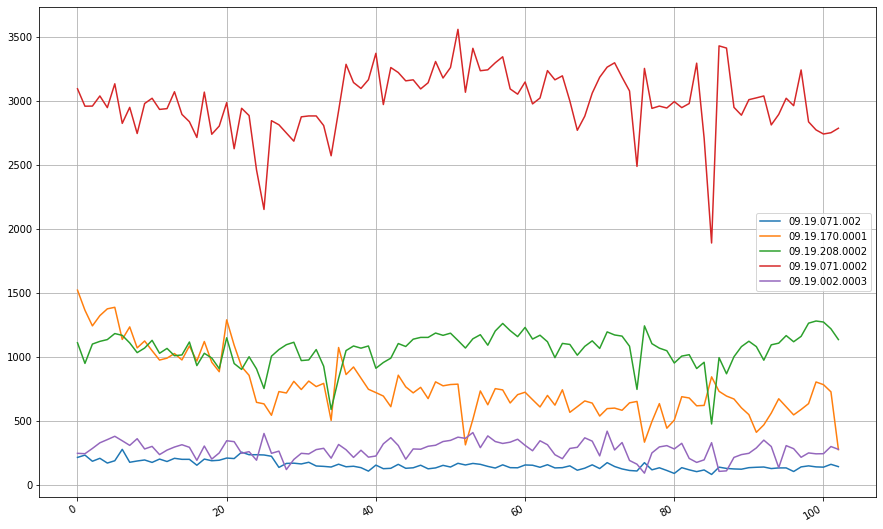

In [6]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()
for stock in stock_codes:
    one_stock_df = weekly_sales_df[weekly_sales_df["sth_stok_kod"] == stock]
    one_stock_df = one_stock_df.reset_index(drop=False)
    ax.plot(one_stock_df.index, one_stock_df.weekly_sale, label=stock)
plt.gcf().autofmt_xdate()
plt.legend()
plt.grid(True)
plt.show()

## Case1, change rate < %10 for product B (09.19.170.0001) (slice date: 2018-03-19)

In [7]:
case_df, actual_df = create_case_df(date='2018-03-19', product_type='milk')
actual_df

sth_stok_kod,PRODUCT A,PRODUCT B,PRODUCT C,PRODUCT D,PRODUCT E
0,140.0,611.0,1171.0,3023.0,347.0
1,160.0,701.0,1120.0,3237.0,316.0


In [8]:
test_df, train_df = get_test_train_df(case_df=case_df, product_type='milk')
predicted_df = predict_from_test_train(test_df=test_df, train_df=train_df, product_type='milk')
predicted_df

,PRODUCT A,PRODUCT B,PRODUCT C,PRODUCT D,PRODUCT E
0,140.000000,611.000000,1171.00000,3023.000000,347.000000
1,143.232713,733.365025,1238.36011,3243.158862,330.281051


In [9]:
create_increased_decreased_df(actual_df=actual_df, predicted_df=predicted_df)

sth_stok_kod,PRODUCT A,PRODUCT B,PRODUCT C,PRODUCT D,PRODUCT E
actual,Increased,Increased,Decreased,Increased,Decreased
predicted,Increased,Increased,Increased,Increased,Decreased


## Case2, %10 < change rate < %15 for product B (09.19.170.0001) (slice date: 2018-07-30)

In [10]:
case_df, actual_df = create_case_df(date='2018-07-30', product_type='milk')
actual_df

sth_stok_kod,PRODUCT A,PRODUCT B,PRODUCT C,PRODUCT D,PRODUCT E
0,137.0,691.0,1008.0,2948.0,327.0
1,120.0,681.0,1019.0,2980.0,209.0


In [11]:
test_df, train_df = get_test_train_df(case_df=case_df, product_type='milk')
predicted_df = predict_from_test_train(test_df=test_df, train_df=train_df, product_type='milk')
predicted_df

,PRODUCT A,PRODUCT B,PRODUCT C,PRODUCT D,PRODUCT E
0,137.000000,691.000000,1008.000000,2948.00000,327.000000
1,142.721968,595.706031,1105.173896,3075.10171,312.908913


In [12]:
create_increased_decreased_df(actual_df=actual_df, predicted_df=predicted_df)

sth_stok_kod,PRODUCT A,PRODUCT B,PRODUCT C,PRODUCT D,PRODUCT E
actual,Decreased,Decreased,Increased,Increased,Decreased
predicted,Increased,Decreased,Increased,Increased,Decreased


## Case3, %15 < change rate < %20 for product B (09.19.170.0001) (slice date: 2018-04-30)

In [13]:
case_df, actual_df = create_case_df(date='2018-04-30', product_type='milk')
actual_df

sth_stok_kod,PRODUCT A,PRODUCT B,PRODUCT C,PRODUCT D,PRODUCT E
0,133.0,658.0,1084.0,2881.0,370.0
1,159.0,641.0,1127.0,3061.0,344.0


In [14]:
test_df, train_df = get_test_train_df(case_df=case_df, product_type='milk')
predicted_df = predict_from_test_train(test_df=test_df, train_df=train_df, product_type='milk')
predicted_df

,PRODUCT A,PRODUCT B,PRODUCT C,PRODUCT D,PRODUCT E
0,133.000000,658.000000,1084.00000,2881.000000,370.000000
1,155.286081,653.030454,1156.67239,3111.365545,384.263826


In [15]:
create_increased_decreased_df(actual_df=actual_df, predicted_df=predicted_df)

sth_stok_kod,PRODUCT A,PRODUCT B,PRODUCT C,PRODUCT D,PRODUCT E
actual,Increased,Decreased,Increased,Increased,Decreased
predicted,Increased,Decreased,Increased,Increased,Increased


# Cheese

In [19]:
stock_codes = ['09.01.071.0009', '09.01.003.0001', '09.01.003.0002']
stock_query = "('" + "\', \'".join(stock_codes) + "')"
weekly_sales_df = pd.read_sql_query("select year(sth_tarih), week_iso(sth_tarih), min(sth_tarih) as week_start_day, sth_stok_kod ,sto_isim, SUM(Satis_Miktar) as weekly_sale, sum(Satis_Tutar) / SUM(Satis_Miktar) as price from DDE_STOK_GUNLUK where sth_stok_kod in {0} and sth_tarih < '2018-12-24' GROUP BY sto_isim, sth_stok_kod, year(sth_tarih), week_iso(sth_tarih) order by year(sth_tarih), week_iso(sth_tarih) asc".format(stock_query), connection)
weekly_sales_df.head(10)

,year,week_iso,week_start_day,sth_stok_kod,sto_isim,weekly_sale,price
0,2017,1,2017-01-02,09.01.003.0002,PINAR BEYAZ PEYNIR 800 GR SALAMURA,42.0,17.377989
1,2017,1,2017-01-02,09.01.003.0001,PINAR BEYAZ PEYNIR 800 GR KAHV.KEYFI,30.0,13.417185
2,2017,1,2017-01-02,09.01.071.0009,SUTAS BEYAZ PEYNIR 700 GR LIGHT,54.0,10.879524
3,2017,2,2017-01-09,09.01.003.0001,PINAR BEYAZ PEYNIR 800 GR KAHV.KEYFI,49.0,13.363100
4,2017,2,2017-01-09,09.01.071.0009,SUTAS BEYAZ PEYNIR 700 GR LIGHT,44.0,11.035298
5,2017,2,2017-01-09,09.01.003.0002,PINAR BEYAZ PEYNIR 800 GR SALAMURA,34.0,17.494646
6,2017,3,2017-01-16,09.01.003.0001,PINAR BEYAZ PEYNIR 800 GR KAHV.KEYFI,39.0,13.406220
7,2017,3,2017-01-16,09.01.003.0002,PINAR BEYAZ PEYNIR 800 GR SALAMURA,39.0,17.528300
8,2017,3,2017-01-16,09.01.071.0009,SUTAS BEYAZ PEYNIR 700 GR LIGHT,55.0,11.054658
9,2017,4,2017-01-23,09.01.003.0001,PINAR BEYAZ PEYNIR 800 GR KAHV.KEYFI,45.0,13.417284


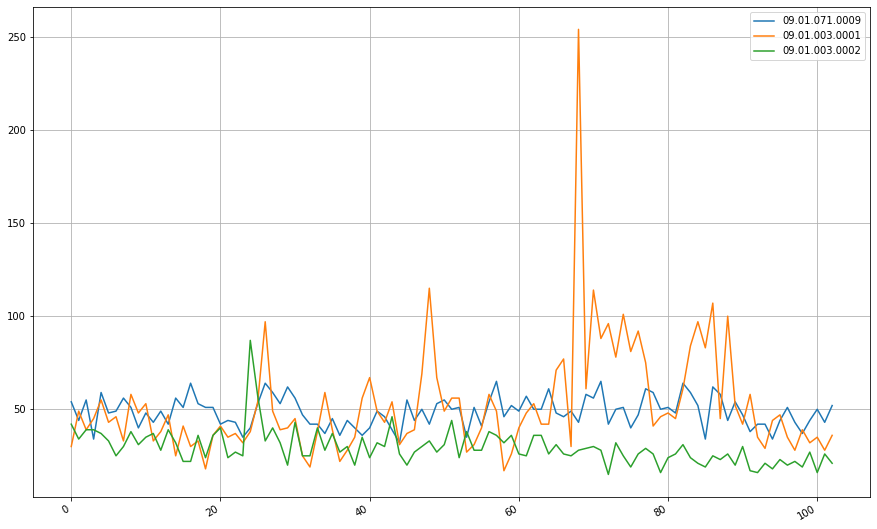

In [20]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()
for stock in stock_codes:
    one_stock_df = weekly_sales_df[weekly_sales_df["sth_stok_kod"] == stock]
    one_stock_df = one_stock_df.reset_index(drop=False)
    ax.plot(one_stock_df.index, one_stock_df.weekly_sale, label=stock)
plt.gcf().autofmt_xdate()
plt.legend()
plt.grid(True)
plt.show()

## Case1, change rate < %40 for one product 2018-04-16

In [21]:
case_df, actual_df = create_case_df(date='2018-04-16', product_type='cheese')
actual_df

sth_stok_kod,PRODUCT A,PRODUCT B,PRODUCT C
0,46.0,77.0,26.0
1,49.0,30.0,25.0


In [22]:
test_df, train_df = get_test_train_df(case_df=case_df, product_type='cheese')
predicted_df = predict_from_test_train(test_df=test_df, train_df=train_df, product_type='cheese')
predicted_df

,PRODUCT A,PRODUCT B,PRODUCT C
0,46.000000,77.000000,26.000000
1,44.611816,20.582792,22.862788


In [23]:
create_increased_decreased_df(actual_df=actual_df, predicted_df=predicted_df)

sth_stok_kod,PRODUCT A,PRODUCT B,PRODUCT C
actual,Increased,Decreased,Decreased
predicted,Decreased,Decreased,Decreased


## Case1, (B) 2018-04-23

In [24]:
case_df, actual_df = create_case_df(date='2018-04-23', product_type='cheese')
actual_df

sth_stok_kod,PRODUCT A,PRODUCT B,PRODUCT C
0,49.0,30.0,25.0
1,43.0,254.0,28.0


In [25]:
test_df, train_df = get_test_train_df(case_df=case_df, product_type='cheese')
predicted_df = predict_from_test_train(test_df=test_df, train_df=train_df, product_type='cheese')
predicted_df

,PRODUCT A,PRODUCT B,PRODUCT C
0,49.000000,30.000000,25.000000
1,58.004341,100.284895,30.102714


In [26]:
create_increased_decreased_df(actual_df=actual_df, predicted_df=predicted_df)

sth_stok_kod,PRODUCT A,PRODUCT B,PRODUCT C
actual,Decreased,Increased,Increased
predicted,Increased,Increased,Increased


## Case2, change rate > %40 for one product 2018-04-30

In [27]:
case_df, actual_df = create_case_df(date='2018-04-30', product_type='cheese')
actual_df

sth_stok_kod,PRODUCT A,PRODUCT B,PRODUCT C
0,43.0,254.0,28.0
1,58.0,61.0,29.0


In [28]:
test_df, train_df = get_test_train_df(case_df=case_df, product_type='cheese')
predicted_df = predict_from_test_train(test_df=test_df, train_df=train_df, product_type='cheese')
predicted_df

,PRODUCT A,PRODUCT B,PRODUCT C
0,43.000000,254.000000,28.000000
1,48.105936,47.550109,24.188787


In [29]:
create_increased_decreased_df(actual_df=actual_df, predicted_df=predicted_df)

sth_stok_kod,PRODUCT A,PRODUCT B,PRODUCT C
actual,Increased,Decreased,Increased
predicted,Increased,Decreased,Decreased
